In [1]:
import pickle

from ACDC.cell_type_annotation import * 

import pandas as pd
import numpy as np
from collections import Counter

from cvxopt import matrix, solvers

path = 'data/AML_benchmark/'
df = pd.read_csv(path + 'AML_benchmark.csv', sep=',', header = 0,)
df = df.drop(['Time', 'Cell_length','file_number', 'event_number', 'DNA1(Ir191)Di',
              'DNA2(Ir193)Di', 'Viability(Pt195)Di', 'subject'], axis = 1)

channels = [item[:item.find('(')] for item in df.columns[:-1]]
df.columns = channels + ['cell_type']

## log transformation
df[channels] = np.arcsinh((df[channels] - 1.0)/5.0)

## discard ungated events
df = df.loc[df['cell_type'] != 'NotDebrisSinglets']

## manual gating ground truth
y0 = df.cell_type.as_matrix().copy()

df = df.drop('cell_type', axis=1)
X0 = df.as_matrix().copy()

## read cell type- marker table
table = pd.read_csv(path + 'AML_table.csv', sep=',', header=0, index_col=0)
table = table.fillna(0)

cts, channels = get_label(table)

In [2]:
import pickle

## compute the gaussian mixture model for each channel
mk_model =  compute_marker_model(df, table, 0.0)

In [3]:
## define some helper dictionaries
idx2ct = [key for idx, key in enumerate(table.index)]
idx2ct.append('unknown')

ct2idx = {key:idx for idx, key in enumerate(table.index)}
ct2idx['unknown'] = len(table.index)
        
ct_score = np.abs(table.as_matrix()).sum(axis = 1)

In [4]:
## compute posterior probs
thres = 0.5
score0 = get_score_mat(X0, [], table, [], mk_model)
score0 = np.concatenate([score0, 1.0 - score0.max(axis = 1)[:, np.newaxis]], axis = 1)

## classify events     
ct_index0 = get_unique_index(X0, score0, table, thres)

In [5]:
## compute average profiles from each partition
ave_mat = []
for i, ct in enumerate(table.index):
    if np.any(ct_index0[:, i] == 1):
        item = X0[ct_index0[:, i] == 1, :]
    else:
        item = X0[score0[:, i] > thres, :]
    ave_mat.append(np.mean(item, axis = 0))
ave_mat= np.vstack(ave_mat)    

## compute average profiles based on manual gating
ct_mat = []
for i, ct in enumerate(table.index):
    ct_mat.append(np.mean(X0[ y0 == ct, :], axis = 0))
ct_mat= np.vstack(ct_mat)    

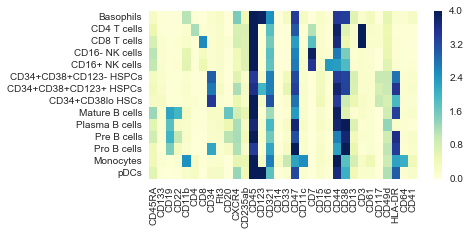

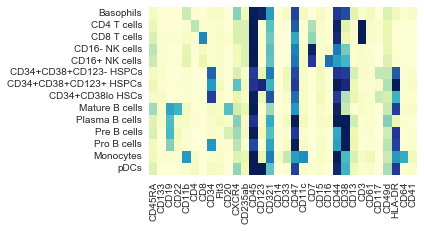

In [6]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib as mpl       
%matplotlib inline

fig = plt.figure(figsize=(6, 3))
feature_mat_df = pd.DataFrame(ave_mat, columns = table.columns, index = table.index)
ax = sns.heatmap(feature_mat_df, vmin=0.0, vmax=4.0, cmap="YlGnBu")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

fig = plt.figure(figsize=(4.8, 3))
ct_feature_df = pd.DataFrame(ct_mat, columns = table.columns, index = table.index)
ax = sns.heatmap(ct_feature_df, vmin=0.0, vmax=4.0, cmap="YlGnBu", cbar=False)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

In [7]:
import phenograph
   
res_c = get_landmarks(X0, score0, ct_index0, idx2ct, phenograph, thres)
        
landmark_mat, landmark_label = output_feature_matrix(res_c, [idx2ct[i] for i in range(len(idx2ct))])   

In [8]:
X_plot = [landmark_mat.copy()]
y_plot = landmark_label[:]

for key in idx2ct:
    tmp = X0[y0 == key, :]
    if tmp.shape[0] > 1000:
        ## to remove randomness, we used the first 1000 events
        ## uncomment the following codes for random sampling
        
        #ind_select = np.random.choice(tmp.shape[0], 1000, replace = False)
        #tmp = tmp[ind_select, :]
        tmp = tmp[:1000, :]
        
    y_plot += [key] * tmp.shape[0]
    X_plot.append(tmp)
         
X_plot = np.vstack(X_plot)  
y_plot = np.array(y_plot)

In [9]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
Xre = tsne.fit_transform(X_plot) 

([], <a list of 0 Text yticklabel objects>)

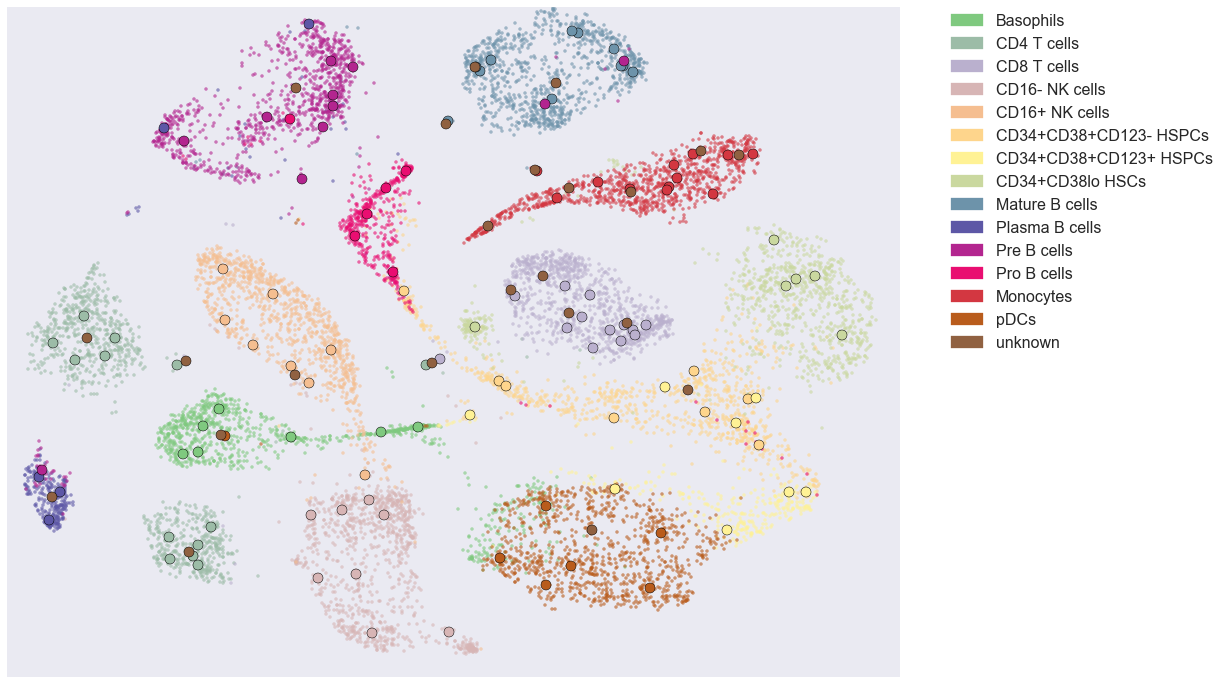

In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl   
import matplotlib.patches as mpatches
%matplotlib inline

cmap = mpl.cm.Accent
fig = plt.figure(1, figsize=(16, 12))

for idx, key in enumerate(idx2ct):
    plt.plot(Xre[y_plot == key, 0], Xre[y_plot == key, 1], '.',
                 color=cmap(idx / float(len(idx2ct))), alpha = 0.6, label = key)
       
for idx, key in enumerate(landmark_label):
    ax, ay = Xre[idx, 0], Xre[idx, 1]
    plt.plot(ax, ay, 'o', color=cmap(ct2idx[key] / float(len(idx2ct))),
              alpha = 1, markersize=10, markeredgewidth=0.5)
patches = []
for idx, key in enumerate(idx2ct):
    patches.append(mpatches.Patch(color=cmap(idx / float(len(idx2ct))), label=key))
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size':16})
        
plt.xticks([])
plt.yticks([])